# Speech Accent Classifier MVP: American vs. Non-American Accents

**Problem Statement**: Using a dataset of 330 sets of [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) coefficients generated from .wav audio files of humans speaking, predict if the accent is american or from another country. This is a binary classification problem.

**Use Case** - Call centers/technical support centers could use this model to automatically screen callers for their accent and match them with an agent (human or not) that speaks in an accent/language they can easily understand.

**Evaluation Metrics** - It is equally important that the model recognizes American or non-American accents. Therefore accuracy is a good measure of model performance, as well as the ROC AOC.

**Future Goal** - Generate additional data for the non-US (ES, FR, GE, IT, UK) accents and create a model that can predict which accent among 6 countries of origin.

_Fokoue, E. (2020). UCI Machine Learning Repository, Irvine, CA: University of California, School of Information and Computer Science._

---

## 1. Setup

Import necessary libraries.

In [506]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [507]:
%autoreload 2

In [233]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

from analysis_utilities import fit_and_cross_validate_score_model, plot_distribution_pair, fit_and_cross_validate_score_roc_auc, fit_and_cross_validate_score_roc_auc_xgboost

Connect to PostgreSQL database located on Amazon EC2 instance.

In [17]:
cnx = create_engine('postgresql://ubuntu@18.191.18.141:5432/speech_accent_classifier')

---
## 2. Data Cleaning

Load data from PostreSQL database.

In [18]:
df_accent = pd.read_sql_query('''SELECT * FROM accent_mfcc''', cnx)
df_accent.head()

,language,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,ES,7.071476,-6.512900,7.650800,11.150783,-7.657312,12.484021,-11.709772,3.426596,1.462715,-2.812753,0.866538,-5.244274
1,ES,10.982967,-5.157445,3.952060,11.529381,-7.638047,12.136098,-12.036247,3.491943,0.595441,-4.508811,2.332147,-6.221857
2,ES,7.827108,-5.477472,7.816257,9.187592,-7.172511,11.715299,-13.847214,4.574075,-1.687559,-7.204041,-0.011847,-6.463144
3,ES,6.744083,-5.688920,6.546789,9.000183,-6.924963,11.710766,-12.374388,6.169879,-0.544747,-6.019237,1.358559,-6.356441
4,ES,5.836843,-5.326557,7.472265,8.847440,-6.773244,12.677218,-12.315061,4.416344,0.193500,-3.644812,2.151239,-6.816310


In [6]:
df_accent.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000
mean,5.645227,-4.270814,2.635319,7.200207,-5.648733,9.810236,-9.408053,5.117328,-1.229432,-2.362288,2.430833,-3.980415
std,5.105302,3.514350,3.635323,4.310095,4.596180,3.624654,2.484117,2.650608,3.634849,5.042034,3.478467,2.985879
min,-6.067831,-14.972962,-6.186583,-8.844231,-15.656596,-3.528964,-15.365665,-2.873862,-15.510974,-11.429178,-13.664104,-13.724103
25%,2.065603,-6.515764,0.137042,4.700874,-8.417684,8.643563,-11.120860,3.482167,-1.749082,-5.083522,1.197789,-5.941409
50%,4.954206,-4.252512,2.029268,7.804680,-6.786670,10.379330,-9.710399,4.843103,-0.389970,-3.323147,3.169703,-4.374334
75%,9.793648,-1.560250,4.178026,10.129165,-4.463308,11.784360,-7.989370,6.588931,0.779993,-1.506037,4.673452,-2.191658
max,17.749851,3.570765,17.066487,16.178942,7.912809,21.445837,-0.424033,13.846083,4.789989,16.326455,9.166066,5.259430


In [7]:
df_accent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   language  329 non-null    object 
 1   x1        329 non-null    float64
 2   x2        329 non-null    float64
 3   x3        329 non-null    float64
 4   x4        329 non-null    float64
 5   x5        329 non-null    float64
 6   x6        329 non-null    float64
 7   x7        329 non-null    float64
 8   x8        329 non-null    float64
 9   x9        329 non-null    float64
 10  x10       329 non-null    float64
 11  x11       329 non-null    float64
 12  x12       329 non-null    float64
dtypes: float64(12), object(1)
memory usage: 33.5+ KB


Data quality is actually really good. Distributions seem reasonable so far, and no null values.

For the MVP model, create a column that is boolean for US or not US.

In [20]:
df_accent['isUS'] = [True if l == 'US' else False for l in df_accent['language']]

## 3. Exploratory Data Analysis (EDA)

### 3.1 Train/Test Split

Split data into train/val and test sets.

In [21]:
X = df_accent.drop(['language', 'isUS'], axis=1)
y = df_accent['isUS']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Merge training features and labels back together for EDA.

In [22]:
df_train = X_train_val.copy()
df_train['isUS'] = y_train_val

While there are some apparent outliers, it seems that since the MFCC features are extracted directly from the audio files, it seems like all data files could be significant. Requires more domain knowledge to interpret.

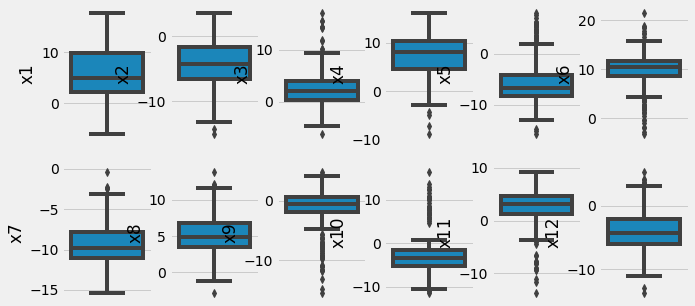

In [11]:
f, axes = plt.subplots(2, 6)
f.set_size_inches(10, 5)
cols = np.array(X_train_val.columns).reshape(2, 6)
for i in range(2):
    for j in range(6):       
        sns.boxplot(df_train[cols[i, j]], orient='v', ax=axes[i, j])

### 3.2 Checking Class Balance

There is **no class imbalance** when considering American vs. non-American accents.

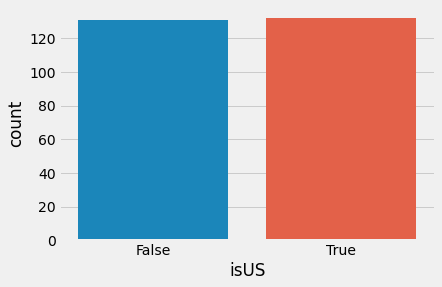

In [12]:
sns.countplot(x='isUS', data=df_train)

### 3.3 Pair Plot
Looking for separability in features. While there is a lot of overlap, there do appear to be some slight separability in the effect of each feature on its predicited label. Something particularly interesting are the several bimodal distributions.

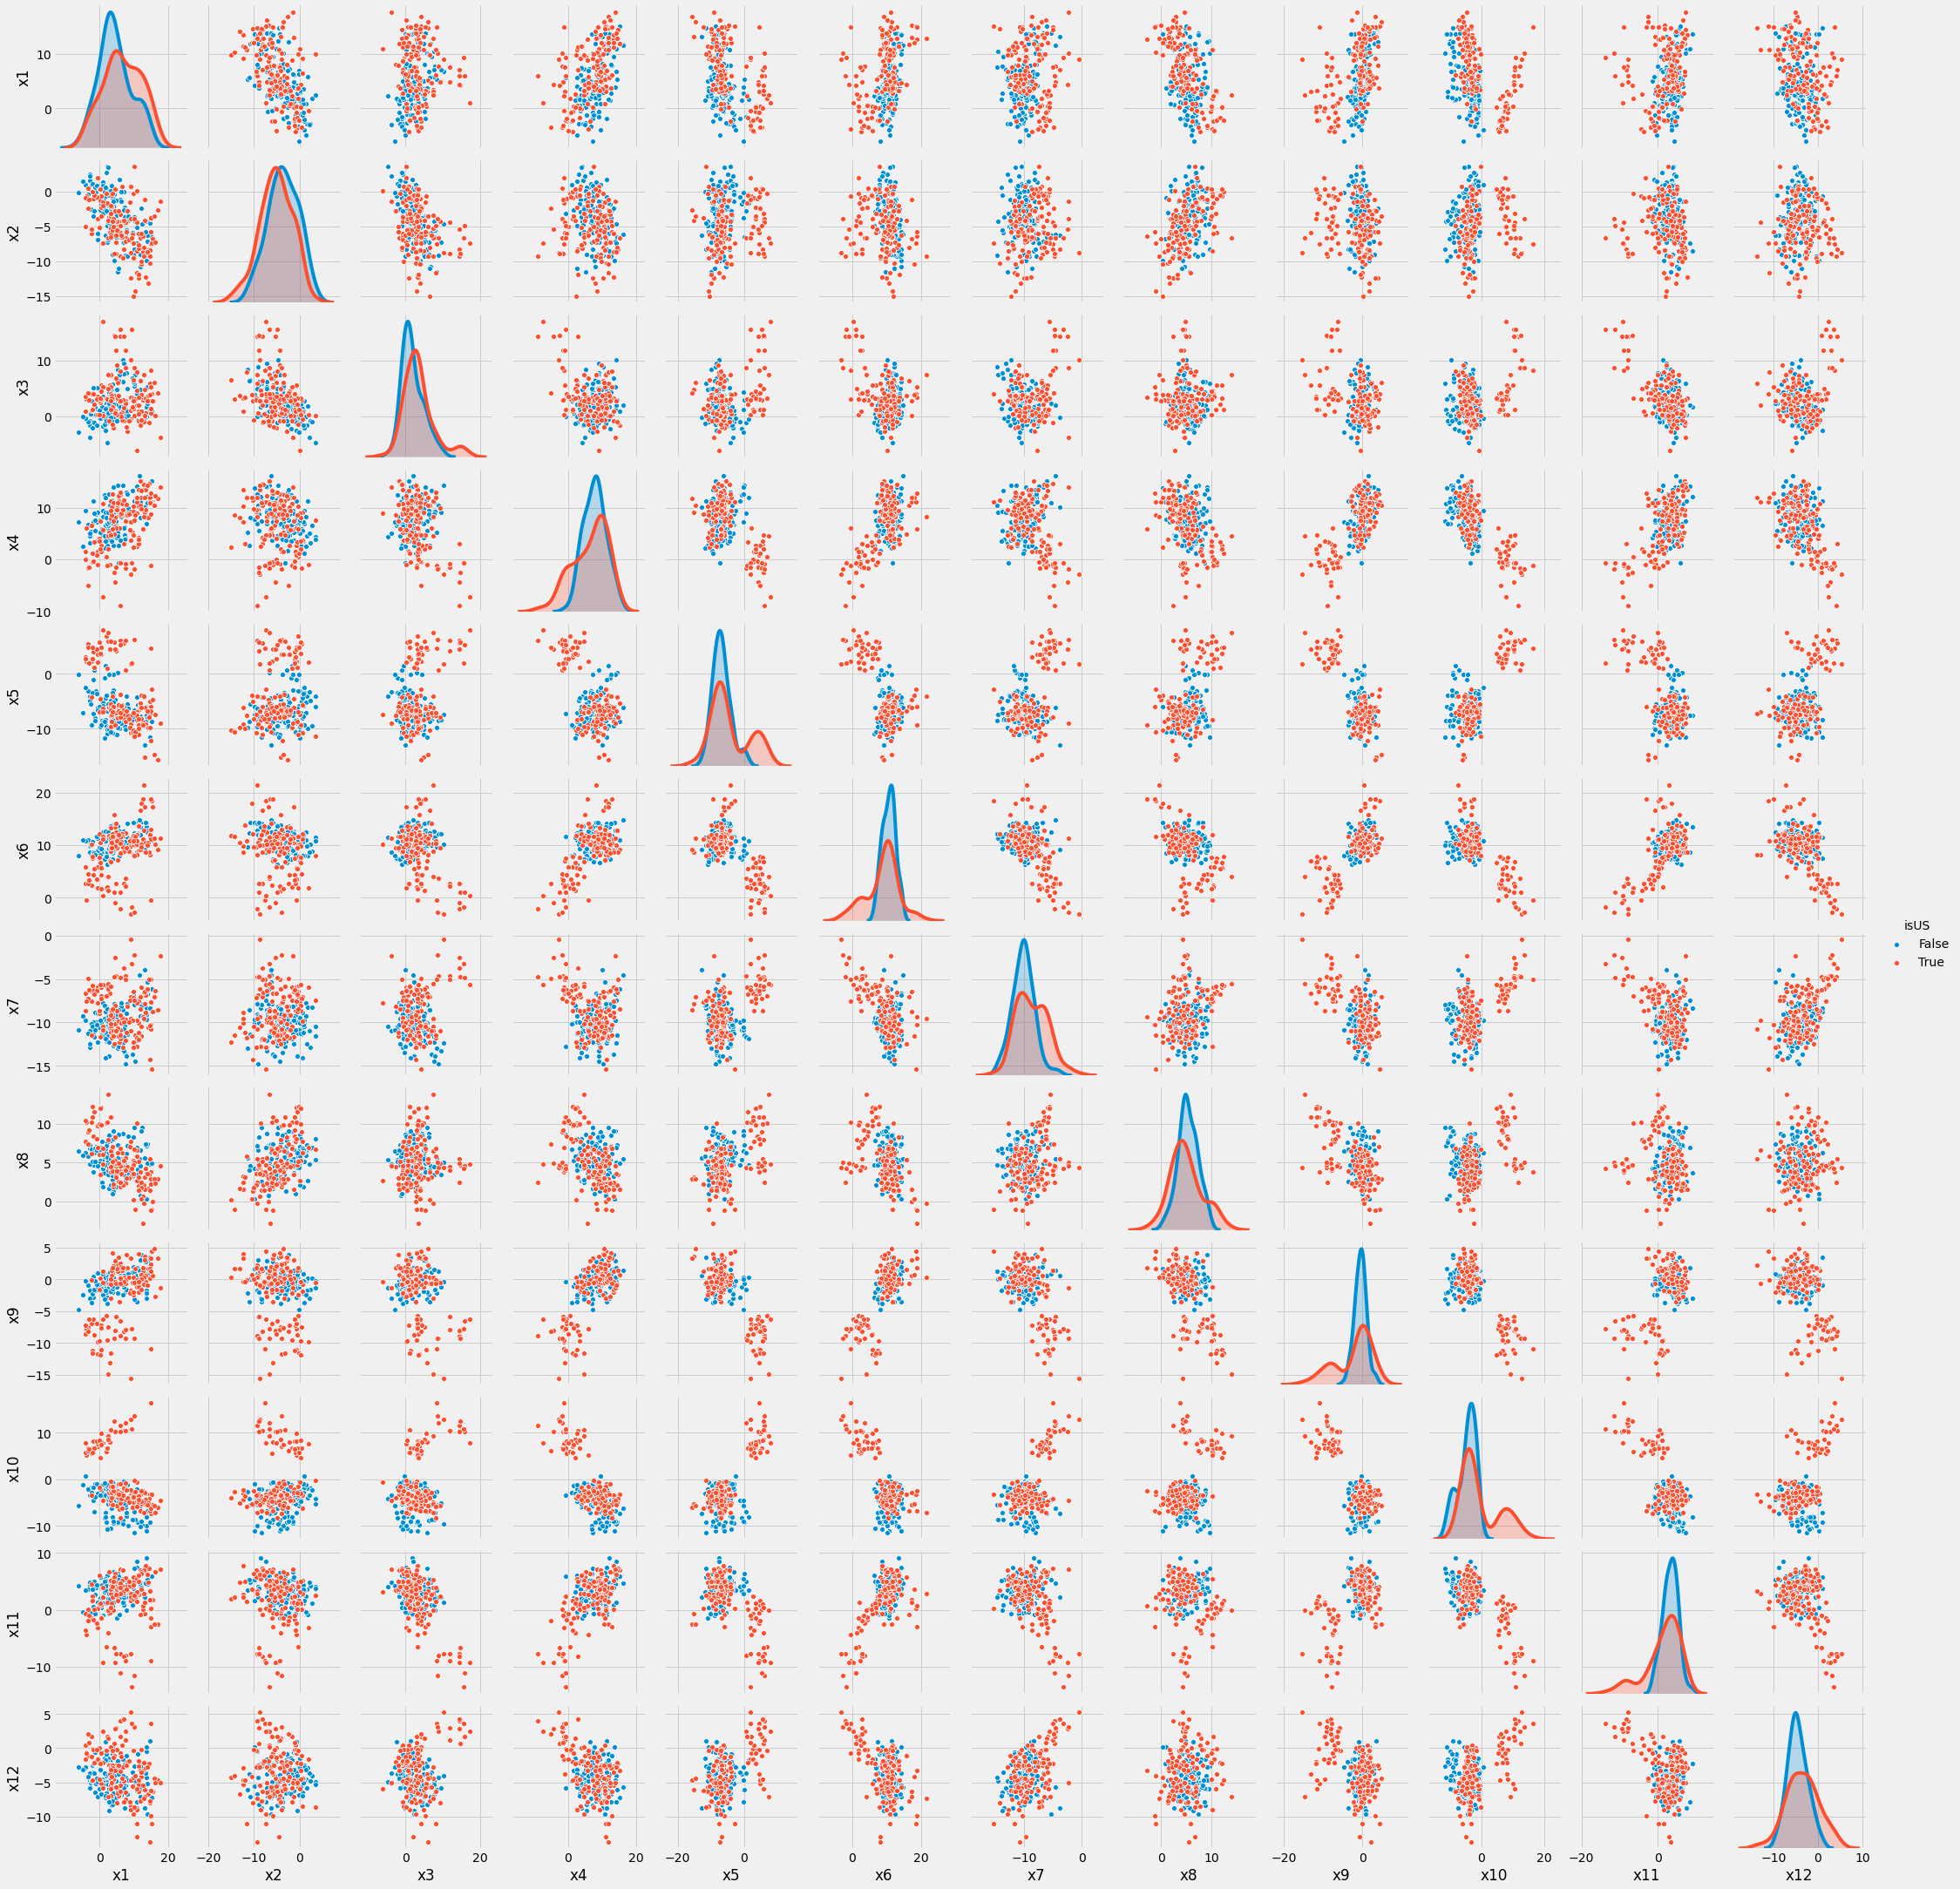

In [13]:
sns.pairplot(df_train, hue='isUS');

### 3.4 Correlation Matrix

Plotting a heat map of the correlation matrix. 

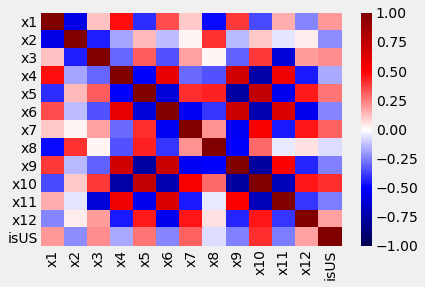

In [14]:
sns.heatmap(df_train.corr(), cmap='seismic', vmin=-1, vmax=1)

## 4. Baseline Models

Fit baseline models for a variety of classification algorithms (including a dummy model). This will serve as a basis for feature engineering and tuning.

### 4.1 Data Prep

In [32]:
X_train_val_baseline = df_train.drop(['isUS'], axis=1)
y_train_val_baseline = df_train['isUS']

### 4.2 Baseline Models

In [34]:
baseline_models = [
    ('Dummy', DummyClassifier(strategy="most_frequent")),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=0)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=0)),
]

In [35]:
metrics = []
roc_auc = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_model(estimator, X_train_val_baseline, y_train_val_baseline))
    roc_auc.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_baseline, y_train_val_baseline))

pd.DataFrame(metrics)

/opt/anaconda3/envs/speechaccentclassifier/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/speechaccentclassifier/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/speechaccentclassifier/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

,Model,ROC AUC,Accuracy,Precision (False),Recall (False),F1 Score (False),Precision (True),Recall (True),F1 Score (True)
0,Dummy,0.500000,0.429536,0.263498,0.600000,0.365633,0.166038,0.400000,0.234566
1,K-Nearest Neighbors,0.908441,0.809797,0.782671,0.847838,0.812080,0.833608,0.773674,0.800954
2,Random Forest,0.907059,0.829028,0.806951,0.870099,0.834155,0.849800,0.792608,0.817668
3,Decision Tree,0.747239,0.745501,0.741555,0.755313,0.746260,0.743917,0.739166,0.739196
4,Naive Bayes,0.728829,0.673004,0.610916,0.936774,0.736899,0.848788,0.412181,0.554310
5,Logistic Regression,0.841978,0.756967,0.732655,0.810832,0.765742,0.782366,0.708171,0.739949


In [36]:
pd.DataFrame(roc_auc)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.964928,0.908441
2,Random Forest,1.000000,0.907059
3,Decision Tree,1.000000,0.741255
4,Naive Bayes,0.738167,0.728829
5,Logistic Regression,0.870813,0.841978


Off the bat, Naive Bayes doesn't look competitive, Decision Tree will tend to be worse than Random Forest in terms of overfitting, and Dummy Model won't be needed for the rest of this analysis, so I will drop those 3.

In [37]:
baseline_models = [
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=0)),
    ('Logistic Regression', LogisticRegression(random_state=0)),
]

## 5. Feature Engineering

Trying out unique features that will boost the performance of the model.

### 5.1 Removing multicolinearities

As a quick, conservative way of removing multicolinearities, if any features have an absolute correlation > 0.7, I'll remove them and see how that affects overfitting.

In [24]:
df_feat_eng = df_train.copy()

Features with > 0.7 absolute correlation.
- `x9` and `x6`
- `x9` and `x4`
- `x9` and `x5`
- `x9` and `x10`
- `x10` and `x5`
- `x10` and `x4`
- `x10` and `x6`
- `x10` and `x11`

Out of those, `x10` has the strongest correlation with `isUS`, so I'll try removing `x4`, `x5`, `x6`, `x9`.

In [147]:
df_feat_eng_x4 = df_feat_eng.drop('x4', axis=1)

In [148]:
X_train_val_x4 = df_feat_eng_x4.drop(['isUS'], axis=1)
y_train_val_x4 = df_feat_eng_x4['isUS']

In [149]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x4, y_train_val_x4))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.962346,0.901869
1,Random Forest,1.000000,0.892553
2,Logistic Regression,0.870106,0.844544


In [150]:
df_feat_eng_x5 = df_feat_eng.drop('x5', axis=1)

In [151]:
X_train_val_x5 = df_feat_eng_x5.drop(['isUS'], axis=1)
y_train_val_x5 = df_feat_eng_x5['isUS']

In [152]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x5, y_train_val_x5))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.961298,0.898100
1,Random Forest,1.000000,0.900906
2,Logistic Regression,0.864846,0.836988


In [153]:
df_feat_eng_x6 = df_feat_eng.drop('x6', axis=1)

In [154]:
X_train_val_x6 = df_feat_eng_x6.drop(['isUS'], axis=1)
y_train_val_x6 = df_feat_eng_x6['isUS']

In [155]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x6, y_train_val_x6))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.952741,0.893869
1,Random Forest,1.000000,0.893904
2,Logistic Regression,0.866348,0.840450


In [25]:
df_feat_eng_x9 = df_feat_eng.drop('x9', axis=1)

In [26]:
X_train_val_x9 = df_feat_eng_x9.drop(['isUS'], axis=1)
y_train_val_x9 = df_feat_eng_x9['isUS']

In [158]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x9, y_train_val_x9))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.965984,0.922821
1,Random Forest,1.000000,0.889397
2,Logistic Regression,0.868859,0.840751


Removing both `x4` and `x9` might be advantageous. 

In [159]:
df_feat_eng_x4x9 = df_feat_eng.drop(['x4', 'x9'], axis=1)

In [160]:
X_train_val_x4x9 = df_feat_eng_x4x9.drop(['isUS'], axis=1)
y_train_val_x4x9 = df_feat_eng_x4x9['isUS']

In [161]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x4x9, y_train_val_x4x9))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.961147,0.893139
1,Random Forest,1.000000,0.885706
2,Logistic Regression,0.868731,0.842191


It seems like  `x9` is the only possibly-multicolinear feature that reduces overfitting and doesn't negatively impact the scores of all models. For this round of feature engineering I'll only remove that feature.

In [172]:
df_feat_eng.drop('x9', axis=1, inplace=True)

### 5.2 Bimodal Distribution

Some of the features have bimodal distributions on the positive class. What would happen if I added a categorical feature that gave weight to points that are in that second "hump".

Starting with `x10`, plotting the distribution more up close to see where that separation occurs.

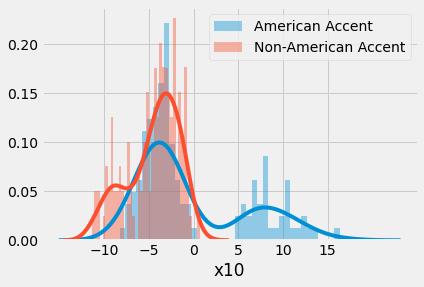

In [75]:
plot_distribution_pair(
    d1=df_train[df_train['isUS']]['x10'],
    d2=df_train[df_train['isUS'] == False]['x10'],
    d1_label='American Accent',
    d2_label='Non-American Accent',
    tick_min=-10,
    tick_max=20,
    tick_interval=5,
    n_bins=40
)

This indicates that a good categorical feature might indicate if `x10` is greater than `2.5`.

In [76]:
df_feat_eng_x10_range = df_feat_eng.copy()
df_feat_eng_x10_range['x10_range'] = df_feat_eng['x10'] > 2.5

Checking baseline models again.

In [77]:
X_train_val_x10_range = df_feat_eng_x10_range.drop('isUS', axis=1)
y_train_val_x10_range = df_feat_eng_x10_range['isUS']

In [78]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x10_range, y_train_val_x10_range))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.965984,0.922821
1,Random Forest,1.000000,0.888730
2,Logistic Regression,0.868030,0.838415


No huge improvement, but some potential here. Repeating this for all of the other features with bimodal disttributions (when `isUS = True`).

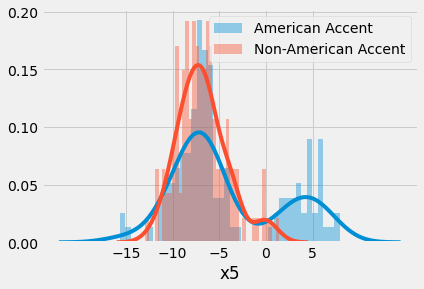

In [79]:
plot_distribution_pair(
    d1=df_train[df_train['isUS']]['x5'],
    d2=df_train[df_train['isUS'] == False]['x5'],
    d1_label='American Accent',
    d2_label='Non-American Accent',
    tick_min=-15,
    tick_max=10,
    tick_interval=5,
    n_bins=40
)

In [80]:
df_feat_eng_x5_range = df_feat_eng.copy()
df_feat_eng_x5_range['x5_range'] = df_feat_eng['x5'] > 2

In [81]:
X_train_val_x5_range = df_feat_eng_x5_range.drop('isUS', axis=1)
y_train_val_x5_range = df_feat_eng_x5_range['isUS']

In [82]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x5_range, y_train_val_x5_range))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.965984,0.922821
1,Random Forest,1.000000,0.893591
2,Logistic Regression,0.868536,0.838404


These features don't seem to add much value to any of the models.

### 5.3 Feature Importances

Train a random forest to look at the current ranking of feature importances.

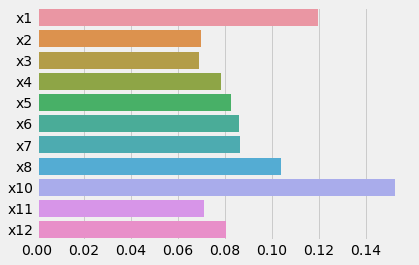

In [163]:
forest_for_importances = RandomForestClassifier(random_state=0)
X_train_val_importance = df_feat_eng.drop(['isUS'], axis=1)
y_train_val_importance = df_feat_eng['isUS']
forest_for_importances.fit(X_train_val_importance, y_train_val_importance)
sns.barplot(y=X_train_val_importance.columns, x=forest_for_importances.feature_importances_)

### 5.4 Interaction Features

Create interaction features.

In [403]:
df_feat_eng_interact = df_feat_eng.copy()
X_feat_eng_preinteract = df_feat_eng_interact.drop('isUS', axis=1)
y_feat_eng_interact = df_feat_eng_interact['isUS']

In [404]:
interact = PolynomialFeatures(interaction_only=True)
X_feat_eng_interact = interact.fit_transform(X_feat_eng_preinteract)

Train model and look at feature importances.

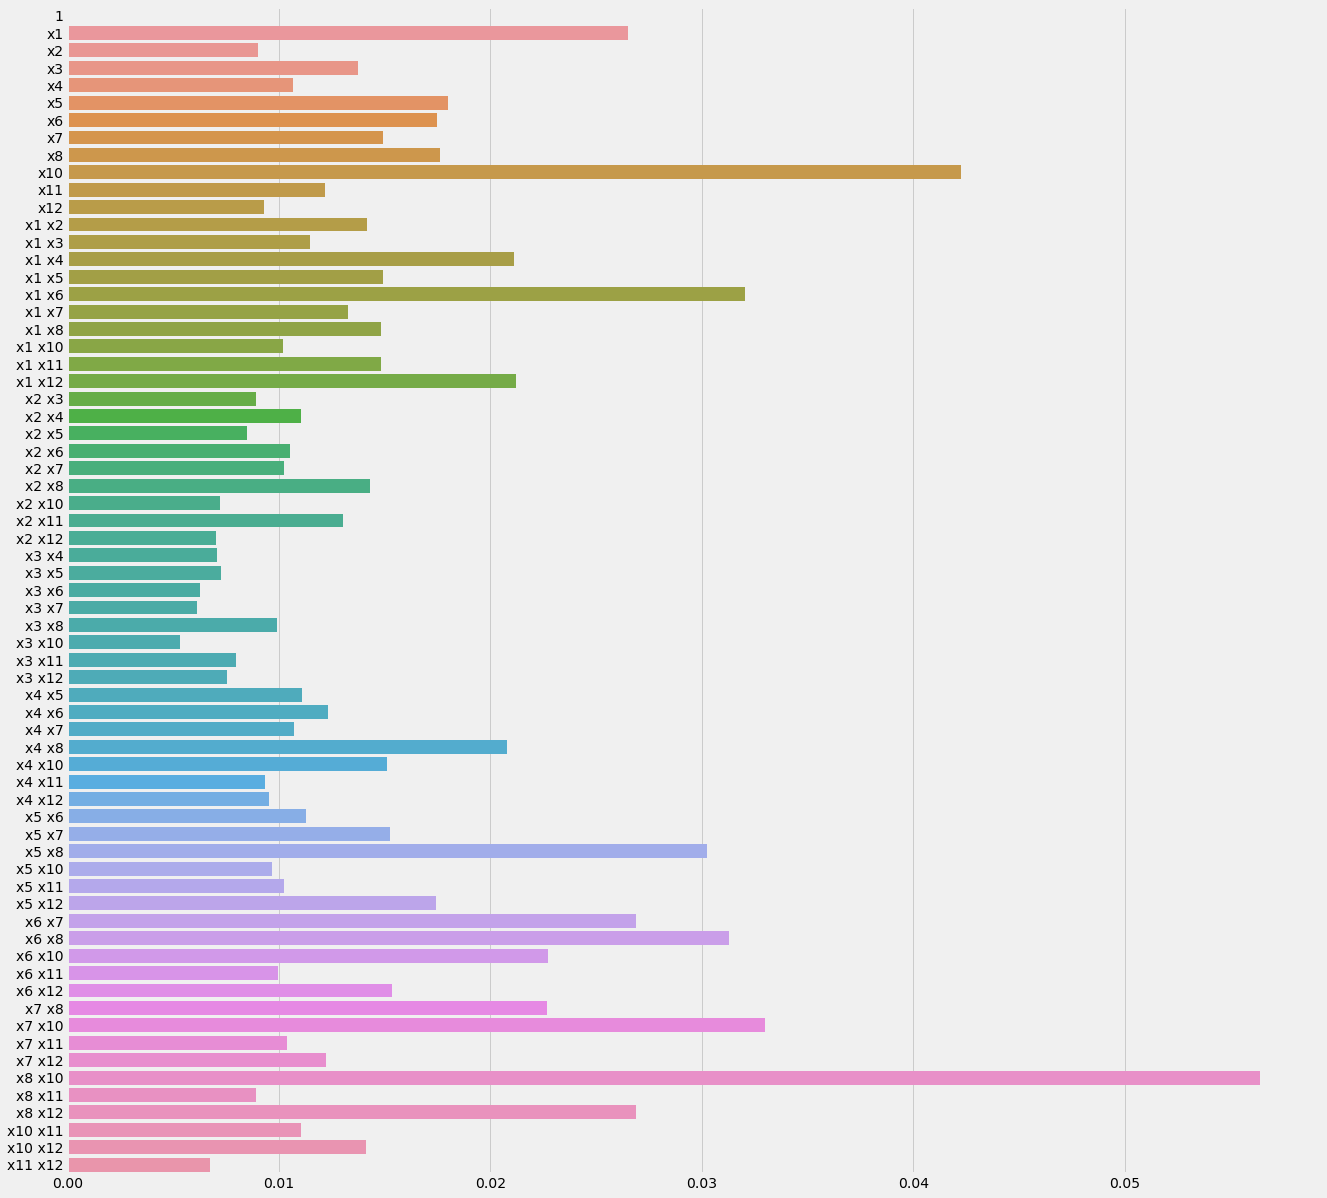

In [405]:
forest_interact = RandomForestClassifier(random_state=0)
forest_interact.fit(X_feat_eng_interact, y_feat_eng_interact)
ax = sns.barplot(y=interact.get_feature_names(input_features=X_feat_eng_preinteract.columns), x=forest_interact.feature_importances_)
plt.gcf().set_size_inches(20, 20)

Looks like some interaction terms stand out. As a test to see how it affects model performance, what happens if I add `x8x10`.

In [406]:
df_feat_eng_interact_x8x10 = df_feat_eng_interact.copy()
df_feat_eng_interact_x8x10['x8x10'] = df_feat_eng_interact['x8']*df_feat_eng_interact['x10']
X_feat_eng_interact_x8x10 = df_feat_eng_interact_x8x10.drop('isUS', axis=1)
y_feat_eng_interact_x8x10 = df_feat_eng_interact_x8x10['isUS']

In [407]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_feat_eng_interact_x8x10, y_feat_eng_interact_x8x10))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.969214,0.921233
1,Random Forest,1.000000,0.888901
2,Logistic Regression,0.866850,0.839291


Adding `x7x10`.

In [413]:
df_feat_eng_interact_x7x10 = df_feat_eng_interact.copy()
df_feat_eng_interact_x7x10['x7x10'] = df_feat_eng_interact['x7']*df_feat_eng_interact['x10']
X_feat_eng_interact_x7x10 = df_feat_eng_interact_x7x10.drop('isUS', axis=1)
y_feat_eng_interact_x7x10 = df_feat_eng_interact_x7x10['isUS']

In [414]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_feat_eng_interact_x7x10, y_feat_eng_interact_x7x10))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.972327,0.921382
1,Random Forest,1.000000,0.885726
2,Logistic Regression,0.867609,0.841336


Adding both `x8x10` and `x7x10`.

In [415]:
df_feat_eng_interact_x8x10_x7x10 = df_feat_eng_interact.copy()
df_feat_eng_interact_x8x10_x7x10['x8x10'] = df_feat_eng_interact['x8']*df_feat_eng_interact['x10']
df_feat_eng_interact_x8x10_x7x10['x7x10'] = df_feat_eng_interact['x7']*df_feat_eng_interact['x10']
X_feat_eng_interact_x8x10_x7x10 = df_feat_eng_interact_x8x10_x7x10.drop('isUS', axis=1)
y_feat_eng_interact_x8x10_x7x10 = df_feat_eng_interact_x8x10_x7x10['isUS']

In [416]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_feat_eng_interact_x8x10_x7x10, y_feat_eng_interact_x8x10_x7x10))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.968489,0.919036
1,Random Forest,1.000000,0.880410
2,Logistic Regression,0.867087,0.838730


What happens if I add the interaction features that have as much/more importance than some of the original features?

In [408]:
df_feat_eng_interact_subset = df_feat_eng.copy()
df_feat_eng_interact_subset['x1x6'] = df_feat_eng_interact['x1']*df_feat_eng_interact['x6']
df_feat_eng_interact_subset['x5x8'] = df_feat_eng_interact['x5']*df_feat_eng_interact['x8']
df_feat_eng_interact_subset['x6x7'] = df_feat_eng_interact['x6']*df_feat_eng_interact['x7']
df_feat_eng_interact_subset['x6x8'] = df_feat_eng_interact['x6']*df_feat_eng_interact['x8']
df_feat_eng_interact_subset['x7x10'] = df_feat_eng_interact['x7']*df_feat_eng_interact['x10']
df_feat_eng_interact_subset['x8x10'] = df_feat_eng_interact['x8']*df_feat_eng_interact['x10']
df_feat_eng_interact_subset['x8x12'] = df_feat_eng_interact['x8']*df_feat_eng_interact['x12']
X_feat_eng_interact_subset = df_feat_eng_interact_subset.drop('isUS', axis=1)
y_feat_eng_interact_subset = df_feat_eng_interact_subset['isUS']

In [409]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_feat_eng_interact_subset, y_feat_eng_interact_subset))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.971766,0.918542
1,Random Forest,1.000000,0.877682
2,Logistic Regression,0.873845,0.831862


What happens if I add ALL of the interaction features?

In [410]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, pd.DataFrame(X_feat_eng_interact), y_feat_eng_interact))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.963496,0.911254
1,Random Forest,1.000000,0.902597
2,Logistic Regression,0.960289,0.902524


The version of the model with just `x9` removed outperforms all of these.

Since there aren't any additional engineered features, and I only needed to drop one column, I decied **not to create a new table in SQL with the final feature set.**

## 6. Initial Model Tuning & Selection

Check how the models are performing at this point.

In [27]:
X_train_val = X_train_val_x9
y_train_val = y_train_val_x9

In [418]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,K-Nearest Neighbors,0.965984,0.922821
1,Random Forest,1.000000,0.889397
2,Logistic Regression,0.868859,0.840751


### 6.1 Logistic Regression

Do a coarse tuning on `C` (inverse regularization strength). 

Since I used ALL of the interaction features, I'll want to mess around with regularization to penalize features and determine what features are needed.

#### 6.1.1 L2 Regularization

In [419]:
logit_models_l2 = [
    ('Logistic Regression (C=0.0001)', LogisticRegression(C=0.0001, random_state=0)),
    ('Logistic Regression (C=0.001)', LogisticRegression(C=0.001, random_state=0)),
    ('Logistic Regression (C=0.01)', LogisticRegression(C=0.01, random_state=0)),
    ('Logistic Regression (C=0.1)', LogisticRegression(C=0.1, random_state=0)),
    ('Logistic Regression (C=1)', LogisticRegression(random_state=0)),
    ('Logistic Regression (C=10)', LogisticRegression(random_state=0, max_iter=1000))
]

In [420]:
metrics = []
for estimator in logit_models_l2:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Logistic Regression (C=0.0001),0.785616,0.761919
1,Logistic Regression (C=0.001),0.800663,0.772891
2,Logistic Regression (C=0.01),0.832062,0.814623
3,Logistic Regression (C=0.1),0.854929,0.831706
4,Logistic Regression (C=1),0.868859,0.840751
5,Logistic Regression (C=10),0.868859,0.840751


Zoom in on `C` to get the optimal reduction of overfitting.

In [426]:
logit_models_l2_2 = [(f'Logistic Regression (C={c})', LogisticRegression(C=c, random_state=0)) for c in np.arange(0.1, 10, 0.1)]
metrics = []
for estimator in logit_models_l2_2:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))

Plot the difference between Train and Validation ROC AUC to minimize overfitting.

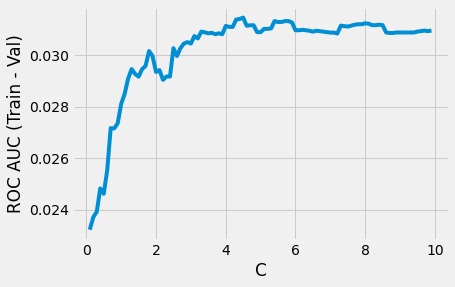

In [428]:
metrics_logit = pd.DataFrame(metrics)
metrics_logit['C'] = np.arange(0.1, 10, 0.1)
metrics_logit['ROC AUC (Train - Val)'] = metrics_logit['ROC AUC (Train)'] - metrics_logit['ROC AUC (Val)']
sns.lineplot(x='C', y='ROC AUC (Train - Val)', data=metrics_logit)

Zoom in on the lowest region.

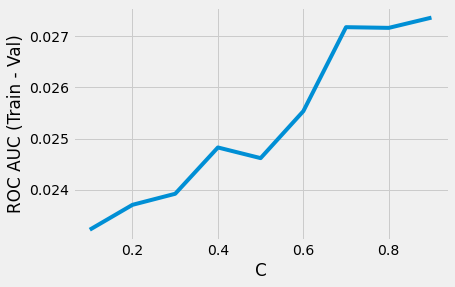

In [432]:
logit_models_l2_3 = [(f'Logistic Regression (C={c})', LogisticRegression(C=c, random_state=0)) for c in np.arange(0.1, 1, 0.1)]
metrics = []
for estimator in logit_models_l2_3:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
metrics_logit = pd.DataFrame(metrics)
metrics_logit['C'] = np.arange(0.1, 1, 0.1)
metrics_logit['ROC AUC (Train - Val)'] = metrics_logit['ROC AUC (Train)'] - metrics_logit['ROC AUC (Val)']
sns.lineplot(x='C', y='ROC AUC (Train - Val)', data=metrics_logit)

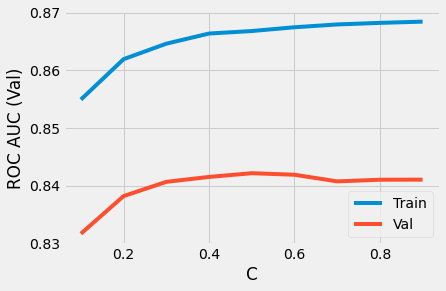

In [434]:
sns.lineplot(x='C', y='ROC AUC (Train)', data=metrics_logit)
sns.lineplot(x='C', y='ROC AUC (Val)', data=metrics_logit)
plt.legend(['Train', 'Val'])

Regularization term `C = 0.5` yields the least overfitting. I did this manually for learning reasons - using `LogisticRegressionCV` yields `C` in the same range.

In [438]:
logit_cv_l2 = LogisticRegressionCV(Cs=np.arange(0.1, 1.0, 0.1), cv=5, random_state=0)
logit_cv_l2.fit(X_train_val, y_train_val)
logit_cv_l2.C_

array([0.1])

Looking at the scores more in depth.

In [440]:
pd.DataFrame([fit_and_cross_validate_score_roc_auc(('Logit C = 0.5', LogisticRegression(C=0.5, random_state=0)), X_train_val, y_train_val)])

,Model,ROC AUC (Train),ROC AUC (Val)
0,Logit C = 0.5,0.866796,0.842178


#### 6.1.2 L1 Regularization

In [441]:
logit_models_l1 = [
    ('Logistic Regression (C=0.001)', LogisticRegression(C=0.001, random_state=0, penalty='l1', solver='liblinear')),
    ('Logistic Regression (C=0.01)', LogisticRegression(C=0.01, random_state=0, penalty='l1', solver='liblinear')),
    ('Logistic Regression (C=0.1)', LogisticRegression(C=0.1, random_state=0, penalty='l1', solver='liblinear')),
    ('Logistic Regression (C=1)', LogisticRegression(random_state=0, penalty='l1', solver='liblinear')),
    ('Logistic Regression (C=10)', LogisticRegression(random_state=0, max_iter=1000, penalty='l1', solver='liblinear'))
]

In [442]:
metrics = []
for estimator in logit_models_l1:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Logistic Regression (C=0.001),0.500000,0.500000
1,Logistic Regression (C=0.01),0.500000,0.500000
2,Logistic Regression (C=0.1),0.854955,0.849112
3,Logistic Regression (C=1),0.869581,0.844102
4,Logistic Regression (C=10),0.869581,0.844102


In [443]:
logit_models_l1_2 = [(f'Logistic Regression (C={c})', 
                      LogisticRegression(C=c, penalty='l1', solver='liblinear', random_state=0)) for c in np.arange(0.01, 1.0, 0.01)]
metrics = []
for estimator in logit_models_l1_2:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))

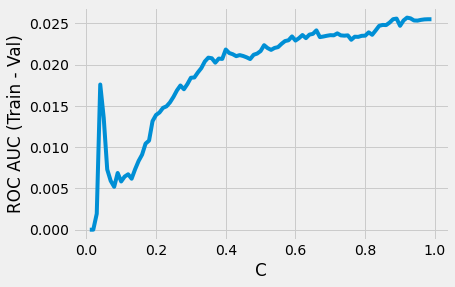

In [444]:
metrics_logit = pd.DataFrame(metrics)
metrics_logit['C'] = np.arange(0.01, 1.0, 0.01)
metrics_logit['ROC AUC (Train - Val)'] = metrics_logit['ROC AUC (Train)'] - metrics_logit['ROC AUC (Val)']
sns.lineplot(x='C', y='ROC AUC (Train - Val)', data=metrics_logit)

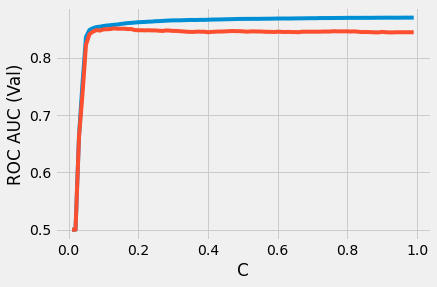

In [445]:
sns.lineplot(x='C', y='ROC AUC (Train)', data=metrics_logit)
sns.lineplot(x='C', y='ROC AUC (Val)', data=metrics_logit)

Zoom in on the lowest region.

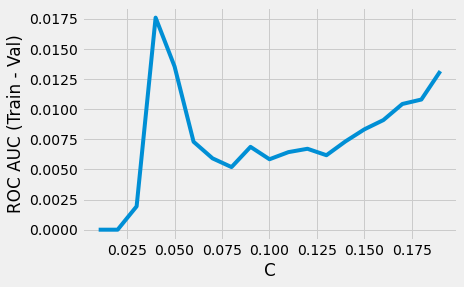

In [446]:
logit_models_l1_3 = [(f'Logistic Regression (C={c})', 
                      LogisticRegression(C=c, penalty='l1', solver='liblinear', random_state=0)) for c in np.arange(0.01, 0.2, 0.01)]
metrics = []
for estimator in logit_models_l1_3:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
metrics_logit = pd.DataFrame(metrics)
metrics_logit['C'] = np.arange(0.01, 0.2, 0.01)
metrics_logit['ROC AUC (Train - Val)'] = metrics_logit['ROC AUC (Train)'] - metrics_logit['ROC AUC (Val)']
sns.lineplot(x='C', y='ROC AUC (Train - Val)', data=metrics_logit)

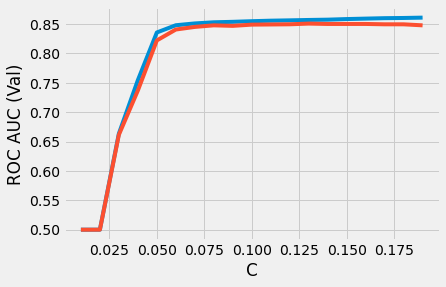

In [447]:
sns.lineplot(x='C', y='ROC AUC (Train)', data=metrics_logit)
sns.lineplot(x='C', y='ROC AUC (Val)', data=metrics_logit)

`0.1` seems like a good compromise between ROC AUC and overfitting.

#### 6.1.3 Throwing Out Features After Regularization

What features did the regularization reduce?

In [454]:
logit_l1_final = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=0)
logit_l1_final.fit(X_train_val, y_train_val)
feature_coefficients = pd.DataFrame({
    'Feature': [f'x{i}' for i in [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]], 
    'Regularized Coefficients': logit_l1_final.coef_[0]
})
zerod_coeffs = feature_coefficients[feature_coefficients['Regularized Coefficients'] == 0]
zerod_coeffs

,Feature,Regularized Coefficients
9,x11,0.0


Drop columns reduced through regularization.

In [455]:
X_train_val_regularized = X_train_val.drop('x11', axis=1)

Fit Logistic Regression again to make sure performance didn't change.

In [456]:
logit_final = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=0)
pd.DataFrame([fit_and_cross_validate_score_roc_auc(('Logit Final', logit_final), X_train_val_regularized, y_train_val)])

,Model,ROC AUC (Train),ROC AUC (Val)
0,Logit Final,0.854955,0.849112


### 6.2 K-Nearest Neighbors

Try a coarse hyperparameter tuning (on number of neighbors).

In [459]:
knn_models_1 = [
    ('KNN (k=5)', KNeighborsClassifier()),
    ('KNN (k=10)', KNeighborsClassifier(n_neighbors=10)),
    ('KNN (k=25)', KNeighborsClassifier(n_neighbors=25)),
    ('KNN (k=50)', KNeighborsClassifier(n_neighbors=50)),
    ('KNN (k=100)', KNeighborsClassifier(n_neighbors=100)),
]

In [463]:
metrics = []
for estimator in knn_models_1:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,KNN (k=5),0.965984,0.922821
1,KNN (k=10),0.941984,0.910657
2,KNN (k=25),0.893252,0.875101
3,KNN (k=50),0.814774,0.811828
4,KNN (k=100),0.754292,0.748819


Seems like the single digits works the best.

In [464]:
knn_models_2 = [(f'KNN (k={k + 1})', KNeighborsClassifier(n_neighbors=k + 1)) for k in range(20)]

In [467]:
metrics = []
for estimator in knn_models_2:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,KNN (k=1),1.000000,0.791610
1,KNN (k=2),0.980451,0.889688
2,KNN (k=3),0.976070,0.904259
3,KNN (k=4),0.971658,0.910450
4,KNN (k=5),0.965984,0.922821
5,KNN (k=6),0.958292,0.921760
6,KNN (k=7),0.953227,0.916008
7,KNN (k=8),0.948528,0.912068
8,KNN (k=9),0.943296,0.907038
9,KNN (k=10),0.941984,0.910657


Looks like `n_neighbors=6` (the baseline KNN) produces the best ROC AUC.

### 6.3 Random Forest

Do coarse tuning on number of estimators to use.

In [468]:
rf_models_1 = [
    ('Random Forest (n=10)', RandomForestClassifier(n_estimators=10, random_state=0)),
    ('Random Forest (n=100)', RandomForestClassifier(n_estimators=100, random_state=0)),
    ('Random Forest (n=1000)', RandomForestClassifier(n_estimators=1000, random_state=0))
]

In [472]:
metrics = []
for estimator in rf_models_1:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Random Forest (n=10),0.999765,0.868240
1,Random Forest (n=100),1.000000,0.889397
2,Random Forest (n=1000),1.000000,0.898287


Seems that the 100's range might be best for number of estimators.

In [473]:
rf_models_2 = [(f'RF (n_estimators={n})', RandomForestClassifier(n_estimators=n, random_state=0)) for n in range(100, 900, 100)]

In [474]:
metrics = []
for estimator in rf_models_2:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,RF (n_estimators=100),1.0,0.889397
1,RF (n_estimators=200),1.0,0.891914
2,RF (n_estimators=300),1.0,0.889940
3,RF (n_estimators=400),1.0,0.891603
4,RF (n_estimators=500),1.0,0.895632
5,RF (n_estimators=600),1.0,0.896064
6,RF (n_estimators=700),1.0,0.898086
7,RF (n_estimators=800),1.0,0.896942


`n_estimators=700` performs the best. Tuning `max_depth` might help reduce overfitting.

In [475]:
rf_models_3 = [(f'Random Forest (max_depth={d})', RandomForestClassifier(n_estimators=700, max_depth=d, random_state=0)) for d in range(1,10)]

In [476]:
metrics = []
for estimator in rf_models_3:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Random Forest (max_depth=1),0.821545,0.727844
1,Random Forest (max_depth=2),0.895815,0.830166
2,Random Forest (max_depth=3),0.938857,0.854149
3,Random Forest (max_depth=4),0.973423,0.872707
4,Random Forest (max_depth=5),0.991843,0.881884
5,Random Forest (max_depth=6),0.998807,0.890755
6,Random Forest (max_depth=7),0.999982,0.894812
7,Random Forest (max_depth=8),1.000000,0.893106
8,Random Forest (max_depth=9),1.000000,0.895225


What about changing the max number of observations required in leaf?

In [481]:
rf_models_4 = [(f'Random Forest (min_samples_leaf={s})', RandomForestClassifier(n_estimators=700, max_depth=2, min_samples_leaf=s, random_state=0)) for s in range(1,10, 1)]

In [482]:
metrics = []
for estimator in rf_models_4:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Random Forest (min_samples_leaf=1),0.895815,0.830166
1,Random Forest (min_samples_leaf=2),0.894945,0.830172
2,Random Forest (min_samples_leaf=3),0.894221,0.829305
3,Random Forest (min_samples_leaf=4),0.893403,0.828107
4,Random Forest (min_samples_leaf=5),0.892338,0.826035
5,Random Forest (min_samples_leaf=6),0.891396,0.825129
6,Random Forest (min_samples_leaf=7),0.890219,0.825476
7,Random Forest (min_samples_leaf=8),0.889658,0.821912
8,Random Forest (min_samples_leaf=9),0.888697,0.823125


### 6.4 Ensembling

Ensembling different combinations of the three models.

In [12]:
scaled_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=6))
scaled_logit = make_pipeline(StandardScaler(), LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))

In [13]:
ensemble1 = VotingClassifier(
    estimators=[('knn', scaled_knn), ('rf', RandomForestClassifier(n_estimators=700, min_samples_leaf=2, max_depth=2)), ('logit', scaled_logit)], 
    voting='soft'
)
scoring = fit_and_cross_validate_score_roc_auc(('Ensemble 1', ensemble1), X_train_val, y_train_val)
pd.DataFrame([scoring])

NameError: name 'X_train_val' is not defined

In [31]:
ensemble2 = VotingClassifier(
    estimators=[('knn', scaled_knn), ('logit', scaled_logit)], 
    voting='soft'
)
scoring = fit_and_cross_validate_score_roc_auc(('Ensemble 2', ensemble2), X_train_val, y_train_val)
pd.DataFrame([scoring])

,Model,ROC AUC (Train),ROC AUC (Val)
0,Ensemble 2,0.956222,0.923632


In [579]:
ensemble3 = VotingClassifier(
    estimators=[('knn', scaled_knn), ('rf', RandomForestClassifier(n_estimators=700, min_samples_leaf=2, max_depth=2))],
    voting='soft'
)
scoring = fit_and_cross_validate_score_roc_auc(('Ensemble 3', ensemble3), X_train_val, y_train_val)
pd.DataFrame([scoring])

,Model,ROC AUC (Train),ROC AUC (Val)
0,Ensemble 3,0.962234,0.917135


In [580]:
ensemble4 = VotingClassifier(
    estimators=[('rf', RandomForestClassifier(n_estimators=700, min_samples_leaf=2, max_depth=2)), ('logit', scaled_logit)],
    voting='soft'
)
scoring = fit_and_cross_validate_score_roc_auc(('Ensemble 4', ensemble4), X_train_val, y_train_val)
pd.DataFrame([scoring])

,Model,ROC AUC (Train),ROC AUC (Val)
0,Ensemble 4,0.882087,0.851555


Ensemble 2 (KNN and Logistic) is the highest performing.

Benchmarking the final ensemble against my best performing singular model.

In [484]:
scoring = fit_and_cross_validate_score_roc_auc(('KNN', KNeighborsClassifier(n_neighbors=6)), X_train_val, y_train_val)
pd.DataFrame([scoring])

,Model,ROC AUC (Train),ROC AUC (Val)
0,KNN,0.958292,0.92176


## 7. Final Tuning & Model Selection

After running the above 2 models (ensemble and KNN), it's sort of hard to choose based on ROC AUC (which are very similar). Looking a bit deeper at the scoring might provide some more insight. 

In [608]:
pd.DataFrame([fit_and_cross_validate_score_model(('Ensemble', ensemble2), X_train_val, y_train_val)])

,Model,ROC AUC,Accuracy,Precision (False),Recall (False),F1 Score (False),Precision (True),Recall (True),F1 Score (True)
0,Ensemble,0.923632,0.847968,0.796884,0.922967,0.854947,0.909071,0.769646,0.833428


In [582]:
pd.DataFrame([fit_and_cross_validate_score_model(('KNN', KNeighborsClassifier(n_neighbors=6)), X_train_val, y_train_val)])

,Model,ROC AUC,Accuracy,Precision (False),Recall (False),F1 Score (False),Precision (True),Recall (True),F1 Score (True)
0,KNN,0.92176,0.83643,0.770049,0.94701,0.848438,0.930397,0.725189,0.814726


These are close contenders. Threshold tune both of them.

### 7.1 Threshold Tuning

#### 7.1.1 KNN

In [584]:
final_knn = KNeighborsClassifier(n_neighbors=6)
final_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [614]:
threshold_scores = [
    fit_and_cross_validate_score_model(('Final KNN', final_knn), X_train_val, y_train_val, threshold=t) for t in np.arange(0.3, 0.7, 0.05)
]
threshold_scores_df = pd.DataFrame(threshold_scores)

Text(0.5, 1.0, 'Threshold Tuning: KNN')

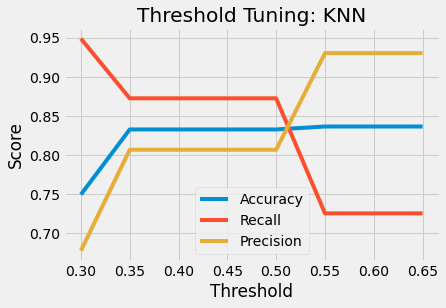

In [615]:
sns.lineplot(x=np.arange(0.3, 0.7, 0.05), y=threshold_scores_df['Accuracy'])
sns.lineplot(x=np.arange(0.3, 0.7, 0.05), y=threshold_scores_df['Recall (True)'])
sns.lineplot(x=np.arange(0.3, 0.7, 0.05), y=threshold_scores_df['Precision (True)'])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(['Accuracy', 'Recall', 'Precision'])
plt.title('Threshold Tuning: KNN')

Accuracy is maximized at a threshold of `0.55`.

In [616]:
pd.DataFrame([fit_and_cross_validate_score_model(('Final KNN', final_knn), X_train_val, y_train_val, threshold=0.55)])

,Model,ROC AUC,Accuracy,Precision (False),Recall (False),F1 Score (False),Precision (True),Recall (True),F1 Score (True)
0,Final KNN,0.92176,0.83643,0.770049,0.94701,0.848438,0.930397,0.725189,0.814726


#### 7.1.2 Ensemble

In [634]:
threshold_scores = [
    fit_and_cross_validate_score_model(('Final Ensemble', ensemble2), X_train_val, y_train_val, threshold=t) for t in np.arange(0.3, 0.7, 0.05)
]
threshold_scores_df = pd.DataFrame(threshold_scores)

Text(0.5, 1.0, 'Threshold Tuning: KNN')

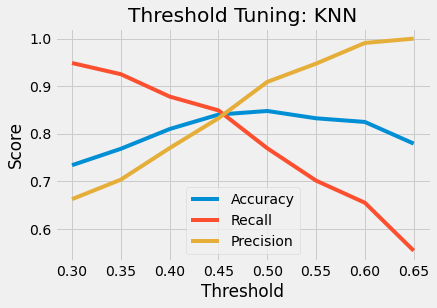

In [635]:
sns.lineplot(x=np.arange(0.3, 0.7, 0.05), y=threshold_scores_df['Accuracy'])
sns.lineplot(x=np.arange(0.3, 0.7, 0.05), y=threshold_scores_df['Recall (True)'])
sns.lineplot(x=np.arange(0.3, 0.7, 0.05), y=threshold_scores_df['Precision (True)'])
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(['Accuracy', 'Recall', 'Precision'])
plt.title('Threshold Tuning: KNN')

In [645]:
pd.DataFrame([fit_and_cross_validate_score_model(('Final Ensemble', ensemble2), X_train_val, y_train_val, threshold=0.46)])

,Model,ROC AUC,Accuracy,Precision (False),Recall (False),F1 Score (False),Precision (True),Recall (True),F1 Score (True)
0,Final Ensemble,0.923632,0.847968,0.836807,0.853018,0.844323,0.85243,0.839641,0.845558


### 7.2 Model Selection

The **ensemble** model will be deployed with a threshold of 0.46.

In [32]:
final_model = ensemble2

## 8. Bonus Modeling: XGBoost

XGBoost was introduced to us at a later point in the project. I'll use it to see if I can outperform my other models.

### 8.1 Max Depth Optimization

In [370]:
xgb_models_max_depth = [(f'XGB (max_depth={d})', xgb.XGBClassifier( 
    n_estimators=30000,
    max_depth=d,
    objective='binary:logistic',
    learning_rate=.2, 
    subsample=.8,
    min_child_weight=3,
    colsample_bytree=.8
)) for d in range(1, 10)]

In [371]:
metrics = []
for estimator in xgb_models_max_depth:
    metrics.append(fit_and_cross_validate_score_roc_auc_xgboost(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,XGB (max_depth=1,0.901412,0.810920
1,XGB (max_depth=2,0.973707,0.863091
2,XGB (max_depth=3,0.956214,0.867875
3,XGB (max_depth=4,0.971770,0.876178
4,XGB (max_depth=5,0.975277,0.882555
5,XGB (max_depth=6,0.980596,0.879207
6,XGB (max_depth=7,0.980595,0.877467
7,XGB (max_depth=8,0.980595,0.877467
8,XGB (max_depth=9,0.980595,0.877467


Choosing `max_depth = 5`.

### 8.2 Optimizing Learning Rate

In [389]:
xgb_models_learning_rate = [(f'XGB (learning rate={l})', xgb.XGBClassifier( 
    n_estimators=30000,
    max_depth=5,
    objective='binary:logistic',
    learning_rate=l, 
    subsample=.8,
    min_child_weight=3,
    colsample_bytree=.8
)) for l in np.logspace(-3, 3, 10)]

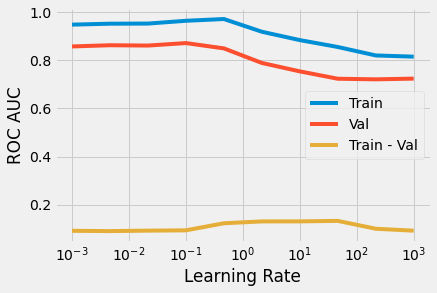

In [393]:
metrics = []
for estimator in xgb_models_learning_rate:
    metrics.append(fit_and_cross_validate_score_roc_auc_xgboost(estimator, X_train_val, y_train_val))

metrics_learning_rate = pd.DataFrame(metrics)
metrics_learning_rate['Learning Rate'] = np.logspace(-3, 3, 10)
metrics_learning_rate['Train - Val'] = metrics_learning_rate['ROC AUC (Train)'] - metrics_learning_rate['ROC AUC (Val)']
sns.lineplot(x='Learning Rate', y='ROC AUC (Train)', data=metrics_learning_rate)
sns.lineplot(x='Learning Rate', y='ROC AUC (Val)', data=metrics_learning_rate)
sns.lineplot(x='Learning Rate', y='Train - Val', data=metrics_learning_rate)
plt.xscale('log')
plt.ylabel('ROC AUC')
plt.legend(['Train', 'Val', 'Train - Val'])

Choosing `learning_rate = 0.1`.

Had fun playing around with XGBoost, but after some tuning, my KNN model is still outperforming this model. 

## 9. Final Model Scoring & Export

### 9.1 Scoring Model on Test Set

Process `X_test` to match the final feature engineered set.

In [647]:
X_train_val.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x10,x11,x12
75,7.266305,-2.226078,1.169851,4.777130,-9.526386,10.532668,-10.750208,5.093525,-3.714795,5.202507,-2.365555
184,3.362900,-5.279764,7.357451,8.326915,-6.115168,10.327969,-10.434079,6.536561,-4.929815,3.849205,-4.384082
17,11.263467,-6.017982,-0.726262,11.959800,-5.667235,12.318475,-7.892121,4.131175,-9.215645,4.770874,-0.822530
24,13.673290,-9.329461,-0.008073,6.951391,-9.590551,12.869720,-9.072661,3.620028,-9.868867,6.307046,-0.387155
180,5.178245,-5.049401,5.980721,10.562531,-8.000220,10.340584,-11.530766,5.072530,-2.365443,4.622242,-5.539080


In [28]:
X_test_prepared = X_test.drop('x9', axis=1)
X_test_prepared.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x10,x11,x12
9,9.803577,-4.485605,9.092753,12.236940,-9.276524,9.972296,-14.003346,6.099329,-9.935106,2.556851,-5.887197
164,4.796552,-0.331376,-1.992637,8.255902,-7.618889,8.342144,-7.300458,3.412246,-0.881845,3.770866,-4.281925
139,4.300413,-4.493086,-1.164146,9.914118,-6.924050,9.733889,-8.321594,3.439366,-2.573591,2.511256,-5.500151
46,6.868094,-10.051478,7.711084,8.888669,-5.472246,14.502432,-8.306207,6.345902,-2.480286,3.915966,-4.976986
94,4.833926,-6.220445,6.431300,4.862321,-11.955694,10.895700,-11.177470,1.999419,-2.905209,-1.606830,-5.648663


Fit final model and score.

In [33]:
final_model.fit(X_train_val, y_train_val)
y_pred_final = final_model.predict_proba(X_test_prepared)[:, 1] > 0.46
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

       False       0.82      1.00      0.90        33
        True       1.00      0.79      0.88        33

    accuracy                           0.89        66
   macro avg       0.91      0.89      0.89        66
weighted avg       0.91      0.89      0.89        66



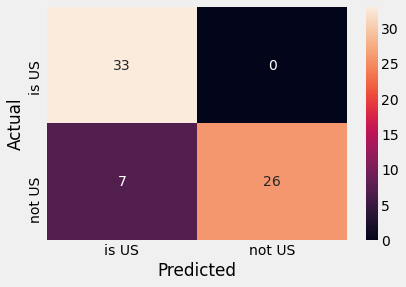

In [36]:
cm = confusion_matrix(y_test, y_pred_final)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual'); 
ax.xaxis.set_ticklabels(['is US', 'not US']); ax.yaxis.set_ticklabels(['is US', 'not US']);

In [37]:
y_scores = final_model.predict_proba(X_test_prepared)[:, 1]
roc_auc_score(y_test, y_scores)

0.9467401285583104

In [39]:
y_scores_val = final_model.predict_proba(X_train_val)[:, 1]
roc_auc_score(y_train_val, y_scores_val)

0.9579574369650705

### 9.2 Persist Model

In [674]:
joblib.dump(final_model, 'final_model.pkl') 

['final_model.pkl']